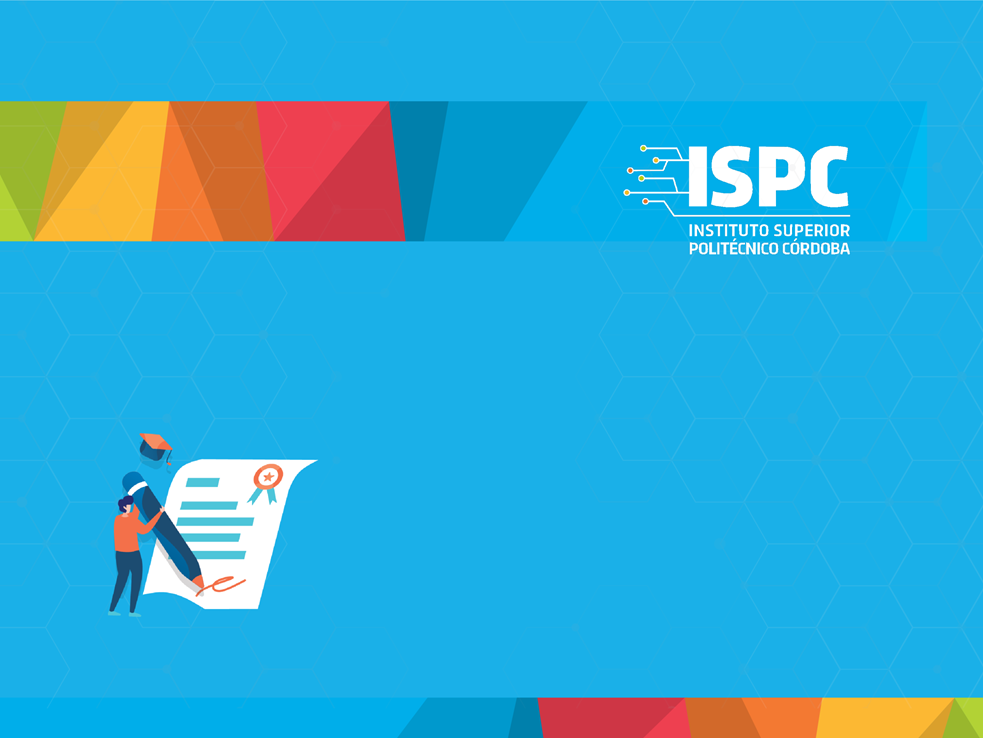

# Consignas:
### Analizar y resolver
### Subir a repositorio de Github, con al menos un pull request, y devolver el link

1- Generar un set de datos, con al menos 4 predictores

2- Dado el siguiente código indicar que tipo de problema instanta resolver. 

3- Evaluar los resultados.

4- Agregar otro algoritmo para resolver sobre el mismo set de datos.





In [6]:
# pip install tensorflow

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.datasets import make_regression

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import tensorflow as tf
from sklearn.metrics import r2_score

# Primer algoritmo - Regresion lineal

En el primer algoritmo uso regresion lineal, es a lo que apuntaba el pseudo-codigo que teniamos. El dataset es generado por SK-Learn

In [8]:
# Generamos el dataset

n_samples, n_features = 1000, 5
rng = np.random.RandomState(0)
X,y = make_regression(n_samples, n_features, noise = 10, random_state=rng)
datos_creados = np.c_[X,y]
datos = pd.DataFrame(datos_creados, columns = ['ventas', 'tv', 'radio', 'periodico', 'redes', 'grafica' ])
datos

,ventas,tv,radio,periodico,redes,grafica
0,-1.718650,0.969624,0.196770,0.143464,-1.056957,-18.793739
1,-0.998192,-1.004323,-0.766705,-1.067742,-1.373043,-209.202089
2,-1.652804,0.174680,-1.400256,0.063896,1.065927,-40.190887
3,-0.422315,0.892474,0.555963,0.228053,0.104714,51.843160
4,-1.023173,0.177158,0.976382,-0.911881,0.106720,-81.601143
...,...,...,...,...,...,...
995,-0.072073,1.665450,2.599867,0.862707,0.884115,219.933596
996,0.945539,0.182100,-0.526243,1.510525,-0.201385,128.914396
997,0.765002,0.030386,0.707135,-2.256250,0.867665,-77.709960
998,-0.704341,0.374948,-0.999278,-0.627299,1.074704,-12.600054


In [9]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
31,grafica,tv,0.613060,0.613060
11,tv,grafica,0.613060,0.613060
33,grafica,periodico,0.605504,0.605504
23,periodico,grafica,0.605504,0.605504
5,ventas,grafica,0.375828,0.375828
30,grafica,ventas,0.375828,0.375828
34,grafica,redes,0.288919,0.288919
29,redes,grafica,0.288919,0.288919
17,radio,grafica,0.127158,0.127158
32,grafica,radio,0.127158,0.127158


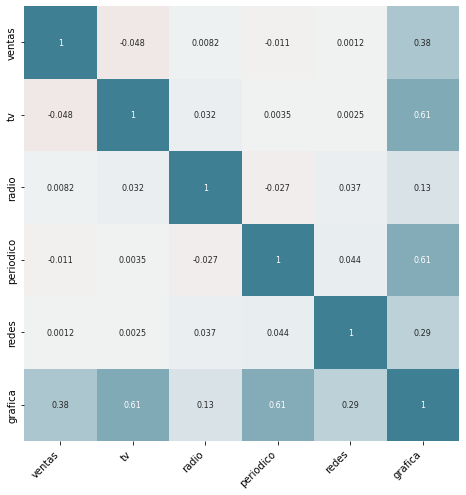

In [10]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20,
                                      220,
                                      n = 200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

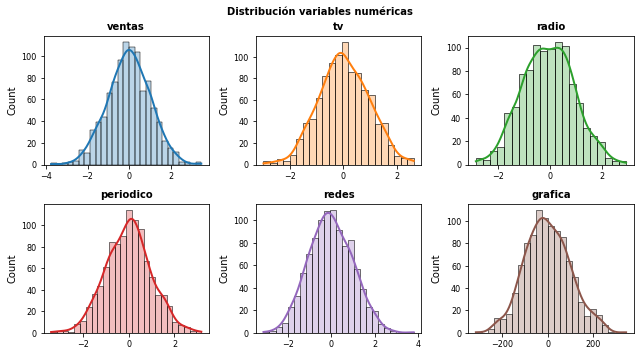

In [11]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

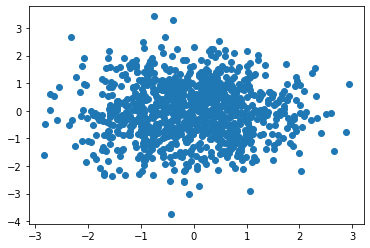

In [12]:
plt.scatter(datos['radio'],datos['ventas'])

In [13]:
# División de los datos en train y test
# ==============================================================================
X = datos[['tv', 'radio', 'periodico', 'redes', 'grafica']]
y = datos['ventas']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y.values.reshape(-1,1),
                                                    train_size   = 0.8,
                                                    random_state = 1234,
                                                    shuffle      = True
                                                    )

In [15]:
# Entrenamos el modelo
# ==============================================================================
lr = LinearRegression()
modelo = lr.fit(X_train,y_train)
y_pred = modelo.predict(X_test)

# Diagnóstico errores (residuos) de las predicciones de entrenamiento
# ==============================================================================

y_train = y_train.flatten()
prediccion_train = modelo.predict(X_train)
residuos_train   = prediccion_train - y_train

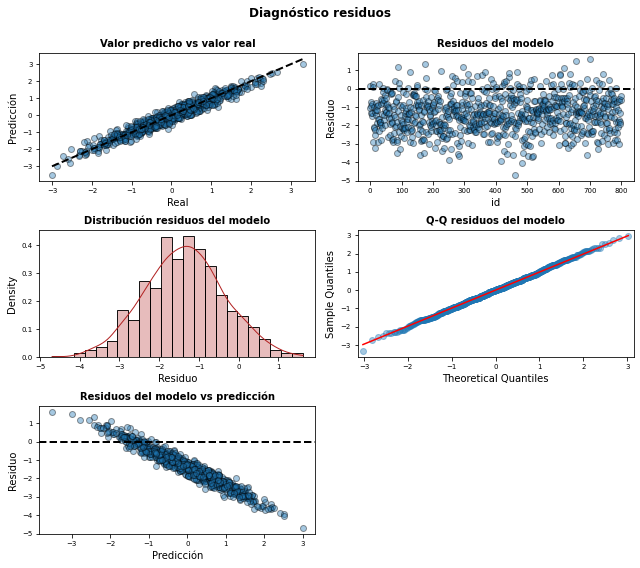

In [16]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         figsize=(9, 8))

axes[0, 0].scatter(y_train, 
                   prediccion_train, 
                   edgecolors = (0, 0, 0), 
                   alpha = 0.4)
axes[0, 0].plot([y_train.min(), 
                 y_train.max()], 
                 [y_train.min(), y_train.max()],
                 'k--', 
                 color = 'black', 
                 lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', 
                     fontsize = 10, 
                     fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), 
                   residuos_train[0],
                   edgecolors=(0, 0, 0), 
                   alpha = 0.4)
axes[0, 1].axhline(y = 0, 
                   linestyle = '--', 
                   color = 'black', 
                   lw=2)
axes[0, 1].set_title('Residuos del modelo', 
                      fontsize = 10, 
                      fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train[0],
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', 
                      fontsize = 10,
                      fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train[0],
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', 
                      fontsize = 10, 
                      fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, 
                   residuos_train[0],
                   edgecolors=(0, 0, 0), 
                   alpha = 0.4)
axes[2, 0].axhline(y = 0, 
                   linestyle = '--', 
                   color = 'black', 
                   lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', 
                      fontsize = 10, 
                      fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', 
            fontsize = 12, 
            fontweight = "bold");

In [35]:
# Evaluamos los resultados

y_pred = modelo.predict(X_test)
lineal_r2 = r2_score(y_test, y_pred)
lineal_comp = pd.DataFrame(list(zip(y_test, y_pred)), columns = ['Actual Values', 'Predicted Values']) 

print('Valor de R2: ' + str(lineal_r2))
print('\nTabla de comparacion: \n\n' + str(lineal_comp))

Valor de R2: 0.9400457749410284

Tabla de comparacion: 

              Actual Values        Predicted Values
0      [1.0056501624766825]    [0.9007328489629786]
1     [-2.3696232933022143]   [-1.9960577528905667]
2      [0.8893759081552546]    [0.6040682980497211]
3     [-1.7622288975408782]   [-1.8046582588626836]
4      [0.9622223812117248]    [0.8635932990200185]
..                      ...                     ...
195    [0.8883388619968426]    [0.8921123726556791]
196   [0.06530560533834807]   [0.23903613857646233]
197   [-0.4779740040404867]   [-0.5592079017541741]
198  [-0.04538336414627235]  [-0.22173989122732968]
199   [-1.4166034824256406]   [-1.6641357209941239]

[200 rows x 2 columns]


# Segundo algoritmo - Red Neuronal

Para este segundo caso utilizo Tensorflow para poder crear la red neuronal, uso esta libreria por que ya la use con anterioridad entonces trabajo comodo.

In [20]:
# Estructura de la red
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 64, activation = tf.nn.relu, input_shape = [X_train.shape[1]]),
    tf.keras.layers.Dense(units = 32, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 1)
    ])

In [36]:
# Definimos el optimizador
optimizador = tf.keras.optimizers.RMSprop(0.001)

# Compilamos el modelo con la funcion de perdida, optimizador y las metricas para evaluar el comportamiento
model.compile(loss = 'mse', 
            optimizer = optimizador,
            metrics = ['mae','mse'])
            
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Entrenamos la red
history = model.fit(X_train, 
                    y_train, 
                    epochs = 750)#, validation_data=(X_test, y_test))

Epoch 1/750
25/25 [==============================] - 1s 2ms/step - loss: 0.0692 - mae: 0.1828 - mse: 0.0692
Epoch 2/750
25/25 [==============================] - 0s 3ms/step - loss: 0.0626 - mae: 0.1785 - mse: 0.0626
Epoch 3/750
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.1697 - mse: 0.0542
Epoch 4/750
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - mae: 0.1610 - mse: 0.0470
Epoch 5/750
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - mae: 0.1671 - mse: 0.0539
Epoch 6/750
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - mae: 0.1660 - mse: 0.0512
Epoch 7/750
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - mae: 0.1670 - mse: 0.0516
Epoch 8/750
25/25 [==============================] - 0s 1ms/step - loss: 0.0542 - mae: 0.1667 - mse: 0.0542
Epoch 9/750
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - mae: 0.1733 - mse: 0.0564
Epoch 10/750
25/25 [========

In [43]:
# Evaluamos los resultados

hist = pd.DataFrame(history.history)
print('Entrenamiento: \n' + str(hist.tail(3)) + '\n')

y_pred = model.predict(X_test)
red_r2 = r2_score(y_test, y_pred)
red_comp = pd.DataFrame(list(zip(y_test,y_pred)), columns = ['Actual Values', 'Predicted Values'])

print('Valor de R2: ' + str(red_r2))
print('Evaluamos la red: ')
loss, mae, mse = model.evaluate(X_test, y_test)
print('\nTabla de comparacion: \n\n' + str(red_comp))

Entrenamiento: 
         loss       mae       mse
747  0.034567  0.134709  0.034567
748  0.028429  0.119895  0.028429
749  0.031056  0.124566  0.031056

7/7 [==============================] - 0s 997us/step
Valor de R2: 0.8806603240302358
Evaluamos la red: 
7/7 [==============================] - 0s 2ms/step - loss: 0.1308 - mae: 0.2917 - mse: 0.1308

Tabla de comparacion: 

              Actual Values Predicted Values
0      [1.0056501624766825]      [0.5304023]
1     [-2.3696232933022143]     [-2.2085674]
2      [0.8893759081552546]      [0.5213346]
3     [-1.7622288975408782]     [-1.6023585]
4      [0.9622223812117248]      [0.7432052]
..                      ...              ...
195    [0.8883388619968426]     [0.67088336]
196   [0.06530560533834807]     [0.42676455]
197   [-0.4779740040404867]     [-0.7091652]
198  [-0.04538336414627235]     [0.33516768]
199   [-1.4166034824256406]     [-1.4560376]

[200 rows x 2 columns]
